In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from random import sample 
from tqdm import tqdm

In [14]:
class indiv():

    # Individual of population

    """

    # ATRIBUTES

    self.gen_length: (int) Length of the image along y axis corresponding to the length of the gen
    self.gen: (int[]) Array of aleles each one corresponding to a row of the image
    self.image: (numpy Array) image to decode in the problem
    self.fitness_hist: (float[]) Array of fitness after every mutation

    # FUNCTIONS

    set_gen: sets the individual's gen to a new one
    get_img: returns self.image
    fenotype: returns the image as it is ordered by the gen
    mutate_swap: swaps 2 alele positions
    mutate_block: moves a block of aleles (stride) to a new position into the gen
    fitness: returns the value of the fitness function corresponding to the actual gen distribution

    """
    
    def __init__(self, image):
        
        self.gen_length = len(image)
        self.gen = np.arange(self.gen_length)
        self.image = image
        self.fitness_hist = []
        self.fitness_hist.append(self.fitness())
    
    def set_gen(self, gen): 

        # Returns the gen            
        self.gen = gen

    def get_img(self):

        # Returns the image
        return self.image

    def fenotype(self):

        # Returns the reconstructed image of this individual acording to his gen
        img_reconstruction = []
        [img_reconstruction.append(self.image[i]) for i in self.gen]
        return np.asarray(img_reconstruction)

    def mutate_swap(self):

        # Selects two random aleles
        first_gen = np.random.randint(0, self.gen_length)
        second_gen = np.random.randint(0, self.gen_length)
        
        # Swaps them
        self.gen[first_gen], self.gen[second_gen] =  self.gen[second_gen], self.gen[first_gen]


    def mutate_block(self, stride=1):

        #set a copy of the actual gen
        gen_prev = self.gen

        #determines the initial, last and destiny index of the slice performed into the gen.
        orig_alelo_idx = np.random.randint(0, self.gen_length - stride)
        end_alelo_idx = orig_alelo_idx + stride
        insert_alelo_idx = np.random.randint(0, self.gen_length - stride)

        #Copy of the gen slice
        sliced_gen = self.gen[orig_alelo_idx:end_alelo_idx]

        ### Compute the new gen
        gen_new = np.delete(self.gen, slice(orig_alelo_idx, end_alelo_idx))
        gen_new = np.insert(gen_new, insert_alelo_idx, sliced_gen)
        self.gen = gen_new

        #If the fitness function is higher than the previous gen undoes the changes
        if self.fitness_hist[-1] > self.fitness():
            self.fitness_hist.append(self.fitness())
        else:
            self.gen = gen_prev
            self.fitness_hist.append(self.fitness())

    def fitness(self):

        # Computes the image corresponding to the aleles position
        image = self.fenotype()

        # Computes the diference between pixels along y axis
        compare = np.diff(image, axis=0)

        # Coputes the squared of that difference
        compare = np.square(compare)

        # Sums them up
        compare = np.sum(compare)

        # Returns fitness value
        return compare

In [15]:
def crossover(indivs, cut_point=0.5):
    
    # 2 parents crossover
        
    # indivs: list of individuals of a population
    # cut_point: idx of alele from 0 to 1 along the gen length

    gl = indivs[0].gen_length # length of gen
    alele_cut_idx = int(cut_point * gl) # alele cut point 
    img = indivs[0].get_img()
    
    # In new offspring gensalieze g    
    children_gens = np.ndarray((2,gl), dtype="int")
    # Set the first part of the gen identical as the parent's one    ildren_gens)
    children_gens[:, :alele_cut_idx] = [indiv.gen[:alele_cut_idx] for indiv in indivs]


    # We take the end (alele_cut_idx:) of the gen of an indiv(0) and sort its values as they appear on the other indiv(1)
    # then they are copied into the offspring
    children_gens[0, alele_cut_idx:] = [alele for alele in indivs[1].gen if alele in indivs[0].gen[alele_cut_idx:]]

    # We take the end (alele_cut_idx:) of the gen of an indiv(1) and sort its values as they appear on the other indiv(0)
    # then they are copied into the offspring
    children_gens[1, alele_cut_idx:] = [alele for alele in indivs[0].gen if alele in indivs[1].gen[alele_cut_idx:]]
    
    # Once we have the gen new offspring objects are initialized

    children = [indiv(img), indiv(img)]

    [indiv.set_gen(gen) for (gen, indiv) in zip(children_gens, children)]

    return children


In [16]:
def simulate(image, indiv_n=1, episodes=10000, plot=True):

    # List of Individuals in the population
    indiv_list = []
    [indiv_list.append(indiv(image)) for i in range(indiv_n)]

    # We store the performance of every individual at every episode
    fitness_performance = np.ndarray((episodes, indiv_n))
    fitness_performance[0] = [indiv.fitness_hist[-1] for indiv in indiv_list]
    best_indiv = indiv_list[np.argmin(fitness_performance[0])]
    best_fitness = min(fitness_performance[0])
    stride = 1
    
    # We run the episodes
    for ep in tqdm(range(episodes)):

        if stride < 20:
            stride = int(1/(1 - ep/episodes))

        # Perform crossover
        if indiv_n > 1:

            random_indiv_index_to_cross = random.sample(range(indiv_n), 2)
            parents_to_cross = [indiv_list[i] for i in random_indiv_index_to_cross]
            children = crossover(parents_to_cross)
            for i in sorted(random_indiv_index_to_cross, reverse=True):
                del indiv_list[i] 
            [indiv_list.append(child) for child in children]
        
        # Perform mutation
        [indiv.mutate_block(stride) for indiv in indiv_list]
        
        
        # We store the performance values
        fitness_performance[ep] = [indiv.fitness_hist[-1] for indiv in indiv_list]
        if best_fitness > min(fitness_performance[ep]):
            best_indiv = indiv_list[np.argmin(fitness_performance[ep])]
            best_fitness = min(fitness_performance[ep])

        # Next Offspring takes best individual gen for the next iteration
        [indiv.set_gen(best_indiv.gen) for indiv in indiv_list]

        # Returns the best indiv at the end of the episode and the fitness performance of every individual

    return fitness_performance, best_indiv

In [17]:
# Set the variables

N_EPISODES = 100000
N_INDIVS = 10
img_idx = 0 # 0, 1, 2

img_path = "./images/img" + str(img_idx) + "-shuffled.txt"
img = np.loadtxt(img_path)

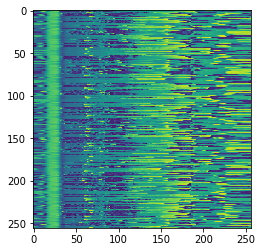

In [18]:
# Shows Initial Image

plt.imshow(img)

In [19]:
# Performs the Evolutive Algorithm
fit, best = simulate(img, N_INDIVS, N_EPISODES)

  0%|          | 225/100000 [00:16<2:09:31, 12.84it/s]

KeyboardInterrupt: 

In [0]:
# Plot the fitness value along the simulation

for i in range(N_INDIVS):
    plt.plot(fit[:, i])

In [0]:
#Shows the reconstructed image

plt.imshow(best.fenotype())